# Project: Modeling the Payout and Profit of Long and Short American-style Call Contracts

## Background
A `call` option is a financial contract that gives the holder the right, but not the obligation, to sell a specified asset, such as stocks, commodities, or currencies, at a predetermined price within a specified time period. Let's consider stock as the underlying asset. A single standard `put` contract controls `100` shares of stock.

In the case of [American](https://www.investopedia.com/terms/a/americanoption.asp) style [put contracts](https://www.investopedia.com/terms/p/putoption.asp), the option buyer can exercise their right at any point between when the contract is purchased and the expiration date. On the other hand, buyers of [European](https://www.investopedia.com/terms/e/europeanoption.asp) style contracts can only exercise their right on the expiration date. 

The business case for buying (or selling) `put` contracts:
* __Buyer (long)__: From the buyer's perspective, `put` contracts allow an investor to benefit from the price movement of `XYZ` to the downside _without_ purchasing `XYZ`. Further, `put` options (again from the buyer's perspective) have _limited downside risk_, i.e., the maximum amount that the holder of the `put` option can lose is the premium paid for the option. Finally, `put` contracts are a mechanism to sell shares of `XYZ` at the strike price of $K$ instead of the market price of $S$. 
* __Seller (short)__: From the seller's perspective, the motivation for selling a `put` contract is to collect the premium $\mathcal{P}$. Put contracts also allow the seller to benefit from the price movement of `XYZ` to the upside _without_ purchasing `XYZ`. However, for a seller, `put` options have _unlimted downside_ risk; thus, `put` options are often only sold by investors who have set aside the required capital to purchase the required number of shares of `XYZ` (known as a [cash secured put position](https://www.fidelity.com/learning-center/investment-products/options/know-about-cash-covered-puts)). Finally, `put` options offer the seller the opportunity to buy shares of `XYZ` at the strike price of $K-\mathcal{P}$ instead of the market price of $S$.

## Payoff, Profit, Premium and Breakeven
The payoff per share of a `put` contract at expiration `T` days in the future $V_{p}(K,S(T))$ is defined as:

$$V_{p}(K,S(T)) = \max\left(K - S(T),~0.0\right)$$

where $K$ denotes the strike price and $S(T)$ represents the share price of the underlying asset `T` days in the future (at expiration). The right (but not the obligation) to sell shares at the strike `K` is not free. The contract `seller` charges the contract `buyer` a premium for each `put` contract $\mathcal{P}_{p}(\dots)$. From the perspective of the `buyer`, the profit per share for the `put` contract $P_{p}$ is the payoff of the contract minus the cost of the contract:

$$P_{p}(K,S(T)) = {V}_{p}(K,S(T)) -  \mathcal{P}_{p}(K,S(T))$$

Thus, from the buyer’s perspective, the share price must fall _below the strike price_ to make up the amount paid for the contract. This is called the breakeven price $\mathcal{B}_{p}(K, S(T))$:

$$\mathcal{B}_{p}(K,S(T)) = K - \mathcal{P}(K,S(T))$$

Finally, the premium (cost) for each `put` contract $\mathcal{P}_{p}(\dots)$ is defined by the expression:

$$\mathcal{P}_{p}(K,S(T))\geq\mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{p}}(K,S(T)\Bigr)$$

where $\mathcal{D}_{T,0}(\bar{r})$ denotes the discount rate between the time when the contract was purchased `0` and contract expiration `T` days in the future. Option contracts use risk-neutral pricing; thus, the discount rate $\bar{r}$ is typically taken as the interest rate on 10-year treasury notes. 

## Setup
Fill me in

In [1]:
include("Include.jl");

## Learning Objective
In this project, you will use the Cox, Ross, and Rubinstein (CRR) binomial lattice model to come the premium of American style contracts and compare this with the prediction of Longstaff and Schwartz as a function of the strike price. We'll compare both methods with real data for the options chain for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) `31-DTE` American `call` options.

To start, load the options data using using the `loadoptionsdata(...)` function and store in the `options_dataset` DataFrame variable:

In [2]:
options_dataset = loadoptionsdata();

Next, let's set constant values for the `call` contracts (these values are the same for each strike price `K`). The time will be calendar days `Δt = 1/365`, the initial share price `Sₒ` is 117.50 USD/share, the days to expiration or `DTE = 31` days, the annual risk-free rate is `r̄ = 0.0418` and the (average) implied volatility `IV = 51.75%`.

In [3]:
Δt = (1.0/365.0);
Sₒ = 117.50;
DTE = 31.0*Δt;
r̄ = 0.0418;
IV = 0.5175;

## Cox, Ross, and Rubinstein (CRR) model

In [4]:
start_strike = 60.0;
stop_strike = 160.0;
K = range(start_strike, stop = stop_strike, step=1) |> collect;
dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ K, options_dataset);
df_CRR_simulation = DataFrame(K=Float64[], premium = Float64[])
for value ∈ K
    
    # comcalle the IV - use average IV is not in dataset
    tmp = dataset[dataset.Strike .== value, :IV]
    IV_value = 0.5175;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end

    # contract model -
    call_contract_model = build(MyAmericanCallContractModel, (
        K = value, IV = first(IV_value), DTE = DTE, sense = 1
    ));
    
    # build tree
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, μ = r̄, h = 100, T = DTE, σ = IV_value, Sₒ = Sₒ);

    # call the longstaff code -  
    price_value = premium(call_contract_model, treemodel) |> x-> round(x,sigdigits=3)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value
    );
    push!(df_CRR_simulation, results_tuple);
end

## Least-Squares Monte Carlo Method of Longstaff and Schwartz

In [5]:
gbm_model = build(MyGeometricBrownianMotionEquityModel, (
    μ = r̄, σ = IV
));

In [6]:
X = sample(gbm_model, (
    T₁ = 0.0, T₂ = DTE, Δt = Δt, Sₒ = Sₒ
), number_of_paths = 1000);

In [7]:
Ŝ = X[:,3:end] |> x-> Matrix(transpose(x)) |> x -> x[:,2:end]
longstaff_model = build(MyLongstaffSchwartzContractPricingModel, (
    S = Ŝ, r̄ = r̄, Δt = Δt
));

In [8]:
start_strike = 60.0;
stop_strike = 160.0;
K = range(start_strike, stop = stop_strike, step=1) |> collect;
dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ K, options_dataset);
df_LSM_simulation = DataFrame(K=Float64[], premium = Float64[])
for value ∈ K
    
    # compute the IV - use average IV is not in dataset
    tmp = dataset[dataset.Strike .== value, :IV]
    IV_value = 0.5175;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end

    # contract model -
    call_contract_model = build(MyAmericanCallContractModel, (
        K = value, IV = first(IV_value), DTE = DTE, sense = 1
    ));

    # call the longstaff code -
    price_value = premium(call_contract_model, longstaff_model)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value
    );
    push!(df_LSM_simulation, results_tuple);
end

## Visualize Premium versus Strike Price

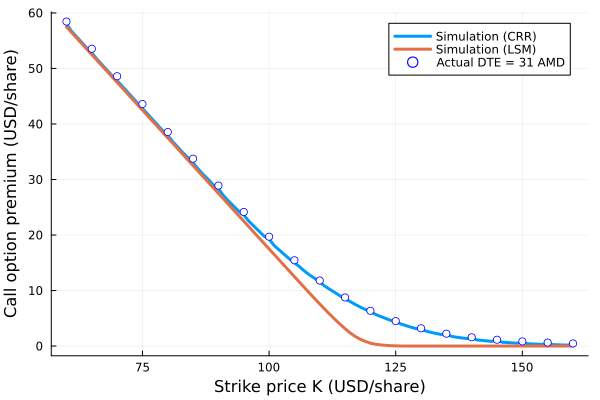

In [10]:
plot(df_CRR_simulation[:,1],df_CRR_simulation[:,2], lw=3, label="Simulation (CRR)")
plot!(df_LSM_simulation[:,1],df_LSM_simulation[:,2], lw=3, label="Simulation (LSM)")
scatter!(dataset[:,:Strike], dataset[:,:Ask],label="Actual DTE = 31 AMD", mc=:white, msc=:blue)
xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Call option premium (USD/share)", fontsize=18) 